In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.constants import N_A
import math
import matplotlib

In [11]:
# Define constants

Target_cell_number = 2e5
well_size = 150e-6
t_end = 1e6
t = np.geomspace(1e-8, t_end, 1000)
tspan = [1e-8, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
sigma = well_size*N_A/Target_cell_number

In [12]:
# Plotting simulations

sns.set_theme()
sns.set_context('talk')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE =10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)

In [13]:
def model(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

In [14]:
def A2_steady_state(x, k2, koff, rtot):
    K2 = k2/koff
    rtot = rtot*K2
    express = x*(rtot -x)/(2*(1+x))

    return express


def A1_steady_state(x, Ainit, kon, koff, k2, rtot):
    k1 = kon/sigma
    Atot = sigma*Ainit
    K1 = k1/koff
    K2 = k2/koff
    Atot = Atot*K2
    rtot = rtot*K2
    K21 = K2/K1

    f0 = 2*rtot*Atot/(1-K21)
    f1 = 2*(rtot-1)*Atot/(1-K21) + 1 - (((rtot + 1)**2)/(1-K21))
    f2 = 2*(1- (Atot/(1-K21)))
    f3 = 1 
    express = (f3*(x**3) + f2*(x**2) + f1*x + f0)
    return express


In [15]:
# Generate initial model simulations

A0s = np.geomspace(1e-12, 1e-4, 100)

A1_st_sim = np.zeros_like(A0s)
A1_st_root = np.zeros_like(A0s)
A2_st_sim = np.zeros_like(A0s)
A2_st_root = np.zeros_like(A0s)
bound_ab_sim = np.zeros_like(A0s)
recep_occ_sim = np.zeros_like(A0s)
mono_bound_ab = np.zeros_like(A0s)

# Parameter values
D = 1e-13
k2 = D/tumour_cell_surface_area
rtot = 1e4
kon = 2.5e5
koff = 1.6e-4
K2 = k2/koff
rtot = 1e4

for i, Ainit in enumerate(A0s):

    K2 = k2/koff
    A1 = (fsolve(A1_steady_state, [100000], args=(Ainit, kon, koff, k2, rtot)))/K2
    A2 = (A2_steady_state(A1*K2, k2, koff, rtot))/K2
    A1_st_sim[i] = A1/(A1 + A2)
    A2_st_sim[i] = A2/(A1 + A2)
    bound_ab_sim[i] = (A1 + A2)/rtot
    recep_occ_sim[i] = (A1 + 2*A2)/rtot
    
    # Solve for monovalent antibody 
    z = solve_ivp(model, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, 0, koff))
    A1 = z.y[0]
    mono_bound_ab[i] = A1[-1]/rtot

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20202/3591537465.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A1_st_sim[i] = A1/(A1 + A2)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20202/3591537465.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A2_st_sim[i] = A2/(A1 + A2)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20202/3591537465.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bound_ab_sim[i] = (A1 + A2

Text(0, 0.5, 'Fraction or Ratio Value')

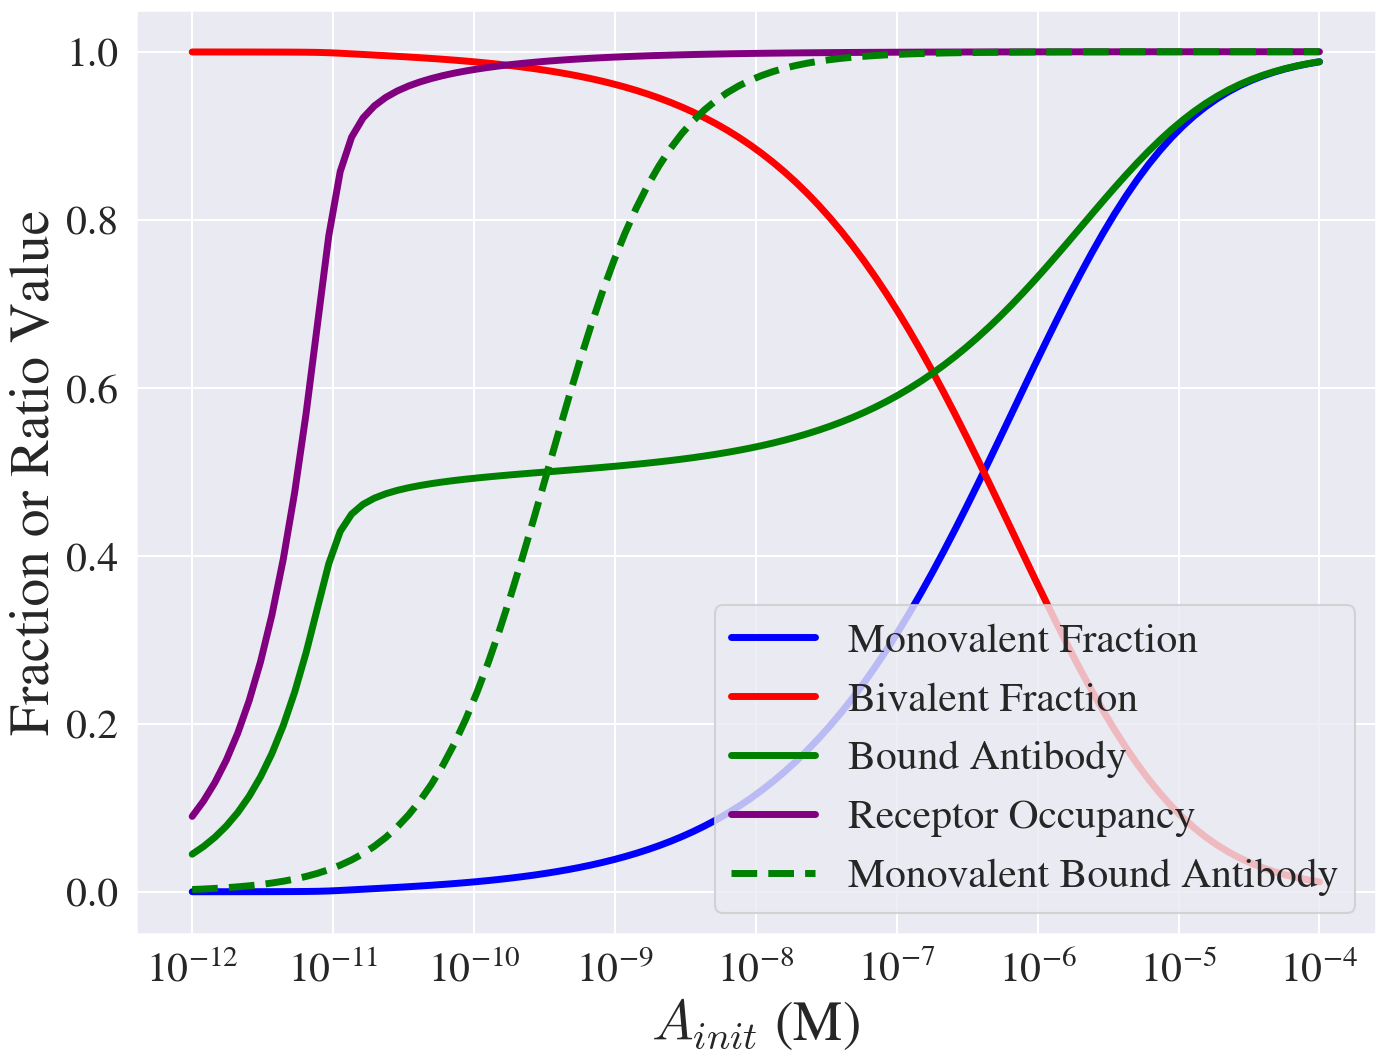

In [16]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(A0s, A1_st_sim, label = r'Monovalent Fraction', color='blue', lw=5)
ax.plot(A0s, A2_st_sim, label = r'Bivalent Fraction', color='red', lw=5)
ax.plot(A0s, bound_ab_sim, label = r'Bound Antibody', color='green', lw=5)
ax.plot(A0s, recep_occ_sim, label= r'Receptor Occupancy', color='purple', lw=5)
ax.plot(A0s, mono_bound_ab, label = r'Monovalent Bound Antibody', color='green', lw=5, linestyle='dashed')


ax.tick_params(axis='both', which='major', labelsize=30)

ax.set_xscale('log')
ax.legend(loc='best', fontsize=30)
ax.set_xlabel(r'$A_{init}$ (M)', fontsize=40)
ax.set_ylabel(r'Fraction or Ratio Value', fontsize = 40)

In [17]:
A0s = np.geomspace(1e-12, 1e-5, 300)
rtots = np.flip(np.geomspace(1e4, 1e6, 300))
sigma = well_size*N_A/Target_cell_number

D = 1e-14
k2 = D/tumour_cell_surface_area

Y = np.zeros((len(rtots), len(rtots)))
Y1 = np.zeros((len(rtots), len(rtots)))
Y2 = np.zeros((len(rtots), len(rtots)))
Y3 = np.zeros((len(rtots), len(rtots)))

for i, rtott in enumerate(rtots):
    for j, Ainit in enumerate(A0s):
        K2 = k2/koff
        A1 = (fsolve(A1_steady_state, [100000], args=(Ainit, kon, koff, k2, rtott)))/K2
        A2 = (A2_steady_state(A1*K2, k2, koff, rtott))/K2
        Y[i, j] =  A1/(A1 + A2)
        Y1[i, j] =  A2/(A1 + A2)
        Y2[i, j] =  (A1+2*A2)/rtott
        Y3[i, j] =  (A1+A2)/rtott


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20202/3766654303.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i, j] =  A1/(A1 + A2)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20202/3766654303.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y1[i, j] =  A2/(A1 + A2)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20202/3766654303.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y2[i, j] =  (A1+2*A2)/rtott
/var/

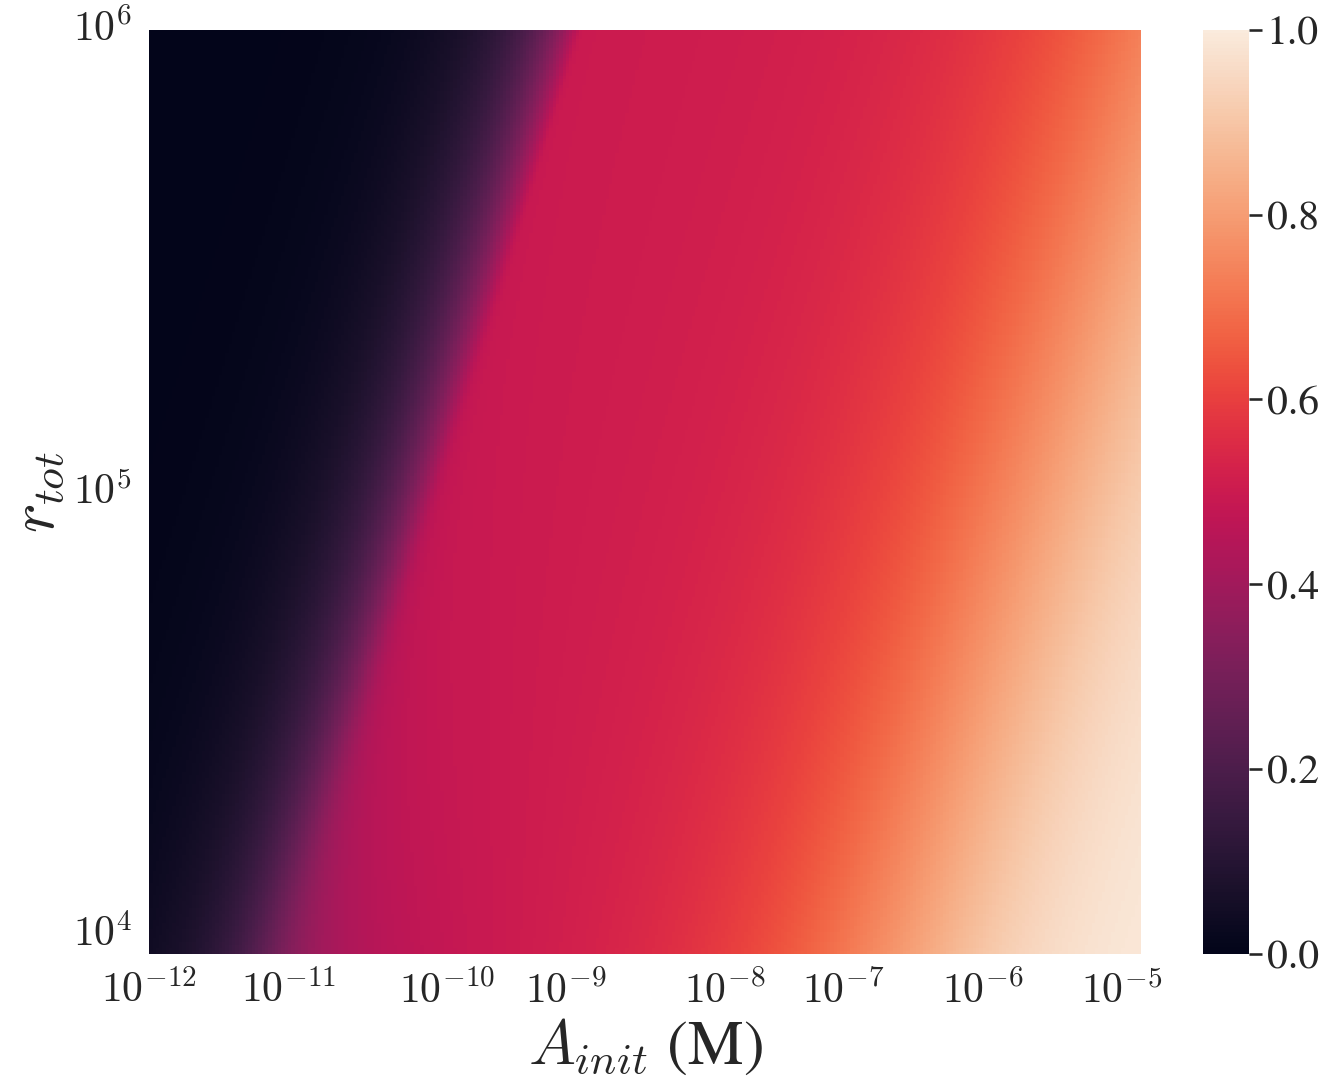

In [18]:
fig, ax = plt.subplots(figsize=(16, 12))
line = sns.heatmap(Y3, xticklabels=True, yticklabels=True, ax=ax, vmin=0, vmax=1) 
ax.set_xticks([0, 7*6, 15*6, 21*6, 29*6, 35*6, 42*6, 49*6])
ax.set_yticks([0, 25*6, 49*6])
ax.set_yticklabels([r'$10^{6}$', r'$10^{5}$', r'$10^{4}$'], fontsize=30)
ax.set_xticklabels([r'$10^{-12}$', r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$'], fontsize=30, rotation=360)
ax.set_xlabel(r'$A_{init}$ (M)', fontsize=45)
ax.set_ylabel(r'$r_{tot}$', fontsize=45)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)